# Analysis Data of Rating Zomato Resturant 
### In this project, we intend to analyze the data of Zomato restaurant and review their ranking method 


### Table content: The steps will generally be as follows:
- Extract and convert data to standard CSV
- Normalize many data
- The information is divided into two segment
- Clustering feature with k-means method unsupervised
- Merging clusters and sticking the label to data about delivery and classy ambiance
- Classification data for predicting user ratting
- Analysis functionality method be run


##### Developed by: M.khaki

#### Data from: kaggle.com


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import json
import csv
import os
from sklearn import svm
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from collections import Counter

itemNumberFile=[75,75,75,75,68]

## Extracte and Convert Data to Standard CSV
In this block, the required for this project is extracted five JSON data from the zomato restaurant on the Kaggle website.
Also, these items have been converted from JSON to CSV for further analysis

In [2]:
def selection_json(values,iterate):
    for i in range(iterate):
        for value in values[i]["restaurants"]:
            item = {
                "id": value["restaurant"]["R"]["res_id"],
                "has_online_delivery":value["restaurant"]["has_online_delivery"],
                "has_table_booking":value["restaurant"]["has_table_booking"],
                "is_delivering_now":value["restaurant"]["is_delivering_now"],
                "switch_to_order_menu":value["restaurant"]["switch_to_order_menu"],
                "cuisines":len(value["restaurant"]["cuisines"].split(",")),
                "average_cost_for_two":value["restaurant"]["average_cost_for_two"],
                "price_range":value["restaurant"]["price_range"],
                "votes":value["restaurant"]["user_rating"]["votes"],
                "aggregate_rating":value["restaurant"]["user_rating"]["aggregate_rating"],
                }
            data.append(item)

data=[]
jsonFile = open('data/file1.json')
values = json.load(jsonFile)
jsonFile.close()
selection_json(values,itemNumberFile[0])
jsonFile = open('data/file2.json')
values = json.load(jsonFile)
jsonFile.close()
selection_json(values,itemNumberFile[1])
jsonFile = open('data/file3.json')
values = json.load(jsonFile)
jsonFile.close()
selection_json(values,itemNumberFile[2])
jsonFile = open('data/file4.json')
values = json.load(jsonFile)
jsonFile.close()
selection_json(values,itemNumberFile[3])
jsonFile = open('data/file5.json')
values = json.load(jsonFile)
jsonFile.close()
selection_json(values,itemNumberFile[4])
jsonData=json.dumps(data)
df = pd.read_json(jsonData)
df.to_csv('zomato_df.csv')
df.describe()

,id,has_online_delivery,has_table_booking,is_delivering_now,switch_to_order_menu,cuisines,average_cost_for_two,price_range,votes,aggregate_rating
count,5.863000e+03,5863.000000,5863.000000,5863.000000,5863.0,5863.000000,5863.000000,5863.000000,5863.000000,5863.000000
mean,8.744872e+06,0.211837,0.172096,0.001364,0.0,2.421457,2512.196657,2.327477,593.585195,3.441958
std,8.420713e+06,0.408645,0.377496,0.036917,0.0,1.256548,23041.702274,0.979424,1004.168178,1.243756
min,4.000000e+00,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.000000
25%,3.035740e+05,0.000000,0.000000,0.000000,0.0,1.000000,150.000000,2.000000,28.000000,3.300000
50%,5.915547e+06,0.000000,0.000000,0.000000,0.0,2.000000,550.000000,2.000000,152.000000,3.800000
75%,1.816160e+07,0.000000,0.000000,0.000000,0.0,3.000000,1100.000000,3.000000,671.500000,4.200000
max,1.849649e+07,1.000000,1.000000,1.000000,0.0,8.000000,800000.000000,4.000000,10934.000000,4.900000


Change vote to vote/max

In [3]:
vote_max=df["votes"].max()
df["votes"]=df["votes"]/vote_max

## Normalize items of classification2
cuisines, average cost for two, price range and votes should be normalized between 0 and 1

In [4]:
df.columns

Index(['id', 'has_online_delivery', 'has_table_booking', 'is_delivering_now',
       'switch_to_order_menu', 'cuisines', 'average_cost_for_two',
       'price_range', 'votes', 'aggregate_rating'],
      dtype='object')

Transformation some data from pandas to numpy for standard use in scikit learn

In [5]:
c2=df[["cuisines","average_cost_for_two","price_range","votes"]].values
df=df[["id", "has_online_delivery", "has_table_booking", "is_delivering_now","switch_to_order_menu","aggregate_rating"]]

Normalize data with min-max scaler 

In [6]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(c2)
c2=scaler.transform(c2)
c2 = pd.DataFrame(data=c2 , columns=["cuisines","average_cost_for_two","price_range","votes"])

Concat class1 and normalized class2 & Ronded aggregate_rating parameter

In [7]:
data = pd.concat([df, c2], axis=1)
data.loc[(data["aggregate_rating"] >= 4.5), 'aggregate_rating'] = 5
data.loc[(data["aggregate_rating"] >= 3.8) & (data["aggregate_rating"] < 4.5), 'aggregate_rating'] = 4
data.loc[(data["aggregate_rating"] >= 2.8) & (data["aggregate_rating"] < 3.8), 'aggregate_rating'] = 3
data.loc[(data["aggregate_rating"] >= 1.8) & (data["aggregate_rating"] < 2.8), 'aggregate_rating'] = 2
data.loc[(data["aggregate_rating"] < 1.8), 'aggregate_rating'] = 1
data["aggregate_rating"]=data["aggregate_rating"].astype(int)
data.head()

,id,has_online_delivery,has_table_booking,is_delivering_now,switch_to_order_menu,aggregate_rating,cuisines,average_cost_for_two,price_range,votes
0,308322,1,1,0,0,4,0.428571,0.002000,0.666667,0.725352
1,18037817,0,1,0,0,5,0.714286,0.001875,0.666667,0.071154
2,312345,1,0,0,0,4,0.428571,0.001063,0.333333,0.140571
3,307490,0,1,0,0,4,0.142857,0.002313,0.666667,0.166728
4,18241537,0,1,0,0,4,0.428571,0.002000,0.666667,0.076825


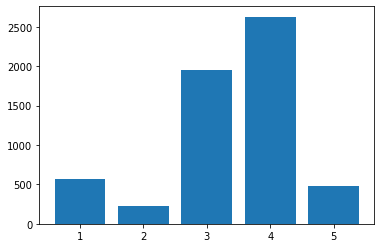

In [8]:
rating_histogram = Counter(data["aggregate_rating"])
plt.bar(rating_histogram.keys(), rating_histogram.values())
plt.show()

# Over sampling
oversampling helps to data balance on user rating

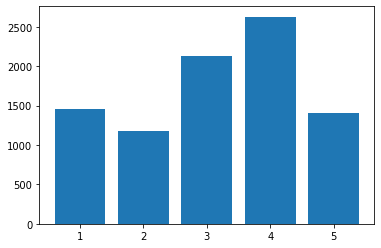

In [9]:
from imblearn.over_sampling import SMOTE
oversampel_x=data[["id", "has_online_delivery", "has_table_booking", "is_delivering_now","switch_to_order_menu","cuisines","average_cost_for_two","price_range","votes"]].values
oversampel_y=data[["aggregate_rating"]].values

ratingCount = []
temp_key = []
for i in range(1,6):  
    ratingCount.append(data.loc[(data["aggregate_rating"] == i )].count().aggregate_rating)
max_key = ratingCount.index(np.max(ratingCount))+1
min_key = ratingCount.index(np.min(ratingCount))+1
if(ratingCount[max_key-1]*0.55 > ratingCount[min_key-1]):
    max_value = ratingCount[max_key-1]
    min_value = (max_value*0.45).astype(int)
else:
    max_value = ratingCount[max_key-1]
    min_value=ratingCount[min_key-1]
    
temp_value = []
temp_grow = []   
for i in range(5):
    if(i!= max_key-1 and i!= min_key-1):
        temp_key.append(i+1) 
for i in range(3):
    temp_grow.append(ratingCount[temp_key[i]-1]/ratingCount[min_key-1])
temp_grow_sum = sum(temp_grow)
for i in range(3):
    temp_grow[i]=temp_grow[i]/temp_grow_sum
for i in range(3):
    temp_value.append(((max_value - min_value)*(temp_grow[i]) + min_value).astype(int)) 
strategy = {
    max_key: max_value,
    min_key: min_value,
    temp_key[0]: temp_value[0],
    temp_key[1]: temp_value[1],
    temp_key[2]: temp_value[2],
}

oversample = SMOTE(sampling_strategy=strategy)
oversampel_x, oversampel_y = oversample.fit_resample(oversampel_x, oversampel_y)
counter = Counter(oversampel_y)
oversampel_x = pd.DataFrame(data=oversampel_x , columns=["id", "has_online_delivery", "has_table_booking", "is_delivering_now","switch_to_order_menu","cuisines","average_cost_for_two","price_range","votes"])
oversampel_y = pd.DataFrame(data=oversampel_y , columns=["aggregate_rating"])
data = pd.concat([oversampel_x, oversampel_y], axis=1)
plt.bar(counter.keys(), counter.values())
plt.show()

Pre processing and Check data type

In [10]:
data.dtypes

id                      float64
has_online_delivery     float64
has_table_booking       float64
is_delivering_now       float64
switch_to_order_menu    float64
cuisines                float64
average_cost_for_two    float64
price_range             float64
votes                   float64
aggregate_rating          int32
dtype: object

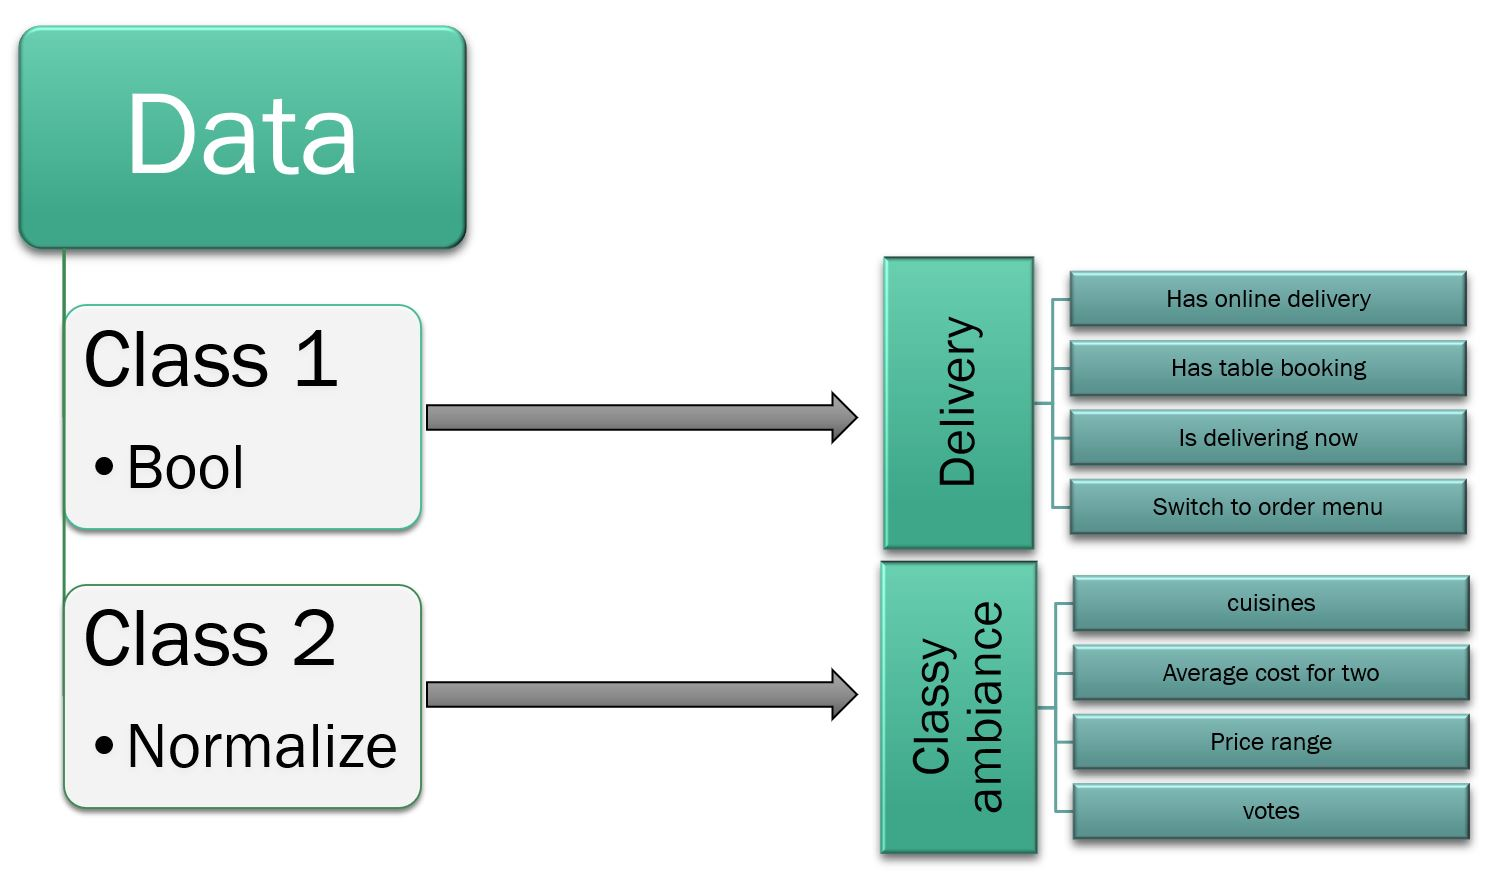

In [11]:
feature_c1 = data[["has_online_delivery", "has_table_booking", "is_delivering_now","switch_to_order_menu"]]
feature_c2 = data[["cuisines","average_cost_for_two","price_range","votes"]]
from IPython import display
display.Image("image/Capture.JPG")

# clustering
with k-means method

In [12]:
k_means1 = KMeans(init = "random", n_clusters = 5, n_init = 20)
k_means1.fit(feature_c1)
labels1 = k_means1.labels_

k_means2 = KMeans(init = "random", n_clusters = 5, n_init = 20)
k_means2.fit(feature_c2)
labels2 = k_means2.labels_

Sorting classfy label

In [13]:
center1 = np.argsort(k_means1.cluster_centers_.sum(axis=1))
lut1 = np.zeros_like(center1)
lut1[center1] = np.arange(1,6)
data["classifier.1"]=lut1[labels1]

center2 = np.argsort(k_means2.cluster_centers_.sum(axis=1))
lut2 = np.zeros_like(center2)
lut2[center2] = np.arange(1,6)
data["classifier.2"]=lut2[labels2]

## Stick label from result clustering 

In [14]:
data.loc[(data["classifier.1"] >= 3) & (data["classifier.2"] >= 3), 'output label'] = 'Delivery & Classy ambiance'
data.loc[(data["classifier.1"] >= 3) & (data["classifier.2"] < 3), 'output label'] = 'Delivery'
data.loc[(data["classifier.1"] < 3) & (data["classifier.2"] >= 3), 'output label'] = 'Classy ambiance'
data.loc[(data["classifier.1"] < 3) & (data["classifier.2"] < 3), 'output label'] = 'Not any'
data.head()

,id,has_online_delivery,has_table_booking,is_delivering_now,switch_to_order_menu,cuisines,average_cost_for_two,price_range,votes,aggregate_rating,classifier.1,classifier.2,output label
0,308322.0,1.0,1.0,0.0,0.0,0.428571,0.002000,0.666667,0.725352,4,5,5,Delivery & Classy ambiance
1,18037817.0,0.0,1.0,0.0,0.0,0.714286,0.001875,0.666667,0.071154,5,3,5,Delivery & Classy ambiance
2,312345.0,1.0,0.0,0.0,0.0,0.428571,0.001063,0.333333,0.140571,4,4,2,Delivery
3,307490.0,0.0,1.0,0.0,0.0,0.142857,0.002313,0.666667,0.166728,4,3,3,Delivery & Classy ambiance
4,18241537.0,0.0,1.0,0.0,0.0,0.428571,0.002000,0.666667,0.076825,4,3,5,Delivery & Classy ambiance


In [15]:
zomato_csv = pd.read_csv('data/zomato.csv',encoding='ISO-8859-1')
zomato_csv = zomato_csv[["Restaurant ID","Restaurant Name","Country Code","City"]]
countryCode = pd.read_excel('data/Country-Code.xlsx')

zomato_csv.columns = ["id", "Restaurant Name", "Country Code", "City"]
countryCode.columns = ["Country Code", "Country"]
data["id"]=data["id"].astype(int)
data_merge = data[["id", "classifier.1", "classifier.2", "aggregate_rating", "output label"]] 


result = pd.merge(zomato_csv, countryCode, how="inner", on="Country Code")
result = result[["id", "Restaurant Name", "Country"]]
result = pd.merge(result, data_merge, how="inner", on="id")
result

,id,Restaurant Name,Country,classifier.1,classifier.2,aggregate_rating,output label
0,6317637,Le Petit Souffle,Phillipines,3,3,5,Delivery & Classy ambiance
1,6304287,Izakaya Kikufuji,Phillipines,3,3,5,Delivery & Classy ambiance
2,6300002,Heat - Edsa Shangri-La,Phillipines,3,4,4,Delivery & Classy ambiance
3,6318506,Ooma,Phillipines,1,4,5,Classy ambiance
4,6314302,Sambo Kojin,Phillipines,3,4,5,Delivery & Classy ambiance
...,...,...,...,...,...,...,...
6998,5915730,NamlÛ± Gurme,Turkey,1,3,4,Classy ambiance
6999,5908749,Ceviz AÛôacÛ±,Turkey,1,3,4,Classy ambiance
7000,5915807,Huqqa,Turkey,1,4,3,Classy ambiance
7001,5916112,Aôôk Kahve,Turkey,1,4,4,Classy ambiance


In [16]:
x = data[["classifier.1", "classifier.2"]]
y = data["aggregate_rating"]
x=np.asarray(x)
y=np.asarray(y).ravel()

## Train/Test
Split data to two part train,test

The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling.

1. Linear
2. Polynomial
3. Gaussian Radial basis function (RBF)
4. Sigmoid

In [17]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size=0.3 , random_state=5)

Comparison kernel method of svm

In [18]:
ks=[]
kernels = ["linear", "poly", "rbf"]
for i in kernels:
    clf_test=svm.SVC(kernel=i)
    clf_test.fit(x_train,y_train)
    yhat_test=clf_test.predict(x_test)
    ks.append(cohen_kappa_score(y_test, yhat_test))
ksd = {'linear': [ks[0]], 'poly': [ks[1]], 'gaussian rbf': [ks[2]]}
ksd

{'linear': [0.2169763258855698],
 'poly': [0.19189514780777495],
 'gaussian rbf': [0.28016306510157896]}

Predict user rating with supervise

In [20]:
clf=svm.SVC(kernel="rbf")
clf.fit(x_train,y_train)
yhat=clf.predict(x_test)

## Confusion matrix and Analysis

In this section, we calculate the accuracy, but since the kappa score is a better benchmark for multi-tag data, we use it as follows:

- Kappa Less Than 0: "VERY BAD"
- Kappa between 0 to 20: "BAD"
- Kappa between 20 to 60: "MIDDLE"
- Kappa between 20 to 60: "GOOD"
- Kappa between 20 to 60: "EXCELLENT"

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           1       0.48      0.71      0.57       444
           2       0.42      0.34      0.38       370
           3       0.35      0.28      0.31       620
           4       0.50      0.60      0.55       787
           5       0.49      0.29      0.37       419

    accuracy                           0.46      2640
   macro avg       0.45      0.44      0.43      2640
weighted avg       0.45      0.46      0.44      2640

Kappa Score 30


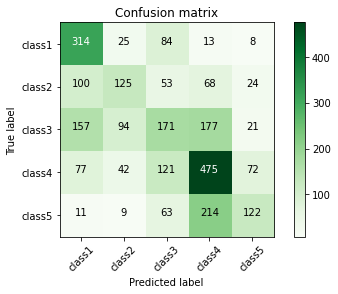

In [22]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,2,3,4,5])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))
print("Kappa Score" , (cohen_kappa_score(y_test, yhat)*100).astype(int))


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['class1','class2','class3','class4','class5'],normalize= False,  title='Confusion matrix')

## Accuracy curve Plot 

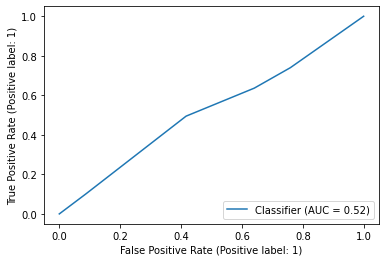

In [23]:
def normalize_numpy(arr):
    norm = np.linalg.norm(arr)
    normal_array = arr/norm
    return normal_array
y_true = y_test == yhat
y_pred = normalize_numpy(yhat)

RocCurveDisplay.from_predictions(y_true, y_pred)
plt.show()

In [24]:
def predict_new_resturant(f1,f2,f3,f4,f5,f6,f7,f8):
    
    new_input1 = np.array([f1,f2,f3,f4])
    temp_dist = 0
    score1 = 0
    for i in range(5):
        dist = np.linalg.norm(new_input1 - k_means1.cluster_centers_[i])
        if(temp_dist > dist or i==0):
            temp_dist = dist
            score1 = i
    
    new_input2 = np.array([f5,f6,f7,f8])
    df_input2 = pd.DataFrame(data=new_input2.reshape(1, -1) , columns=["cuisines","average_cost_for_two","price_range","votes"])
    df_input2 = df_input2.values
    df_input2=scaler.transform(df_input2)
    temp_dist = 0
    score2 = 0
    for i in range(5):
        dist = np.linalg.norm(new_input2 - k_means2.cluster_centers_[i])
        if(temp_dist > dist or i==0):
            temp_dist = dist
            score2 = i 
            
    new_x = np.array([lut1[score1],lut2[score2]]).reshape(1, -1)
    new_yhat=clf.predict(new_x)
    output=[]
    output.append(lut1[score1])
    output.append(lut2[score2])
    output.append(new_yhat)
    return output

In [25]:
f1=0                #has_online_delivery
f2=1                #has_table_booking
f3=0                #is_delivering_now
f4=0                #switch_to_order_menu
f5=3                #cuisines
f6=1200              #average_cost_for_two
f7=3                #price_range
f8=507/vote_max     #votes

output = predict_new_resturant(f1,f2,f3,f4,f5,f6,f7,f8)
cluster_input1= output[0]
cluster_input2= output[1]
new_yhat= output[2][0]

if(cluster_input1>=3 and cluster_input2>=3):
    print("This resturant have: 'Good Delivery & High Classy ambiance' And user rate predict %d out of 5" % (new_yhat))
elif(cluster_input1>=3 and cluster_input2<3):
    print("This resturant have: 'Good Delivery' And user rate predict %d out of 5" % (new_yhat))
elif(cluster_input1<3 and cluster_input2>=3):
    print("This resturant have: 'High Classy ambiance' And user rate predict %d out of 5" % (new_yhat))
elif(cluster_input1<3 and cluster_input2<3):
    print("This resturant have: 'No Delivery No classy ambiance' And user rate predict %d out of 5" % (new_yhat))

This resturant have: 'Good Delivery & High Classy ambiance' And user rate predict 4 out of 5
